In [97]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt


from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

sys.path.append('data\\config')
sys.path.append('ComputableInformationDensity_dev')
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))

from data.config.dicts import DATA_CONFIGS, FIG_FOLDER_CONFIGS

from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid as calc_cid
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean, calc_acf_for_arr, \
    calc_autocorr, rdf2d_mod

plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})
#plt.rcParams['legend.handlelength'] = 0

In [3]:
base_path = f'Z:\\cid\\na'
save_path = f'data\\na'

save_figs = True
verbose = True

ordering='z' # 'h' for hilbert, 'z' for z-order
data_suffix = 'na512'  # 'sd', 'ndg', 's', 'f' or ''    
use_seq = False
seq_prefix = '_seq' if use_seq else ''
ordering_suffix = 'zorder' if ordering=='z' else ''

nbits = 8
window_size=256
nframes = 64
cg = 4

if ordering == 'h':
    output_suffix = f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}'
elif ordering == 'z':
    output_suffix = f'_nx{window_size}nt{nframes}cg{cg}'

data_dict = DATA_CONFIGS #[data_suffix]
fig_folder_dict = FIG_FOLDER_CONFIGS

cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'output_suffix': output_suffix,
    'nbits': nbits,
    'cg': cg,
    'verbose': verbose,
    'ddof': 1,   
    **data_dict[data_suffix]
}

#output_suffix = data_dict[data_suffix]['output_suffix']
figs_save_path = f'data\\figs\\{fig_folder_dict[data_suffix]}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)


ac = AnalyseCID(cid_dict,)
# Set figure save path
ac.figs_save_path = figs_save_path


* temporal corr
* corr func (version kris, version other)

In [27]:
save_fig=True
iterate_frames=True

window_size_dict = {'na512': [16,32,64,128,256],# 128, 256],
                    'na1024': [512],
                    'na2048': [1024],
                    'ndg': [64,128,256,],
                    'pol': [256],
                    's': [256, 512, 1024],
                    'abp': [64],
                    }
nsizes_dict = {'na512': [4,8,16,32,64],
                'na1024': [16,32,60],
                'na2048': [32,],
                'ndg': [16, 32, 64],
                'pol': [15,30,60],
                's': [1,2,4],
                'abp': [16,32],
                }
xlims_dict = {'na512': [0.018, 0.035],
                'na1024': [0.018, 0.035],
                'na2048': [0.018, 0.035],
                'ndg': None,
                'pol': None,
                's': None,
                'abp': None,
                }
ylims_dict = {'na512': [0, 0.8],
                'na1024': None,
                'na2048': [0, 0.8],
                'ndg': None,
                'pol': None,
                's': None,
                'abp': None,
                }


In [28]:
def get_windows_from_string_len(window_size_list, nframes_list, lstring_bits, cg=1):
    """
    Get allowed intervals for CID calculation based on system size and max bits.
    """

    window_sizes = []
    nframes_sizes = []
   

    # get all combinations of window sizes and nframes that fit within lstring_bits
    for window_size in window_size_list:
        for nframes in nframes_list:
            total_bits = int(np.log2(nframes * (window_size / cg) ** 2))
            if total_bits == lstring_bits:
                window_sizes.append(window_size)
                nframes_sizes.append(nframes)

    return window_sizes, nframes_sizes




In [84]:
cg = ac.cid_params[ac.L_list[0]]['coarse_graining_box_length']
ws_base=64
nf_base=64
nbits_str = int(np.log2(nf_base * ws_base * ws_base // (cg * cg)))
nbits_str=10
window_size_list = [16,32,64,128,256,]#512,1024]
nsizes_list = [4,8,16,32,64,]
window_size_list, nsizes_list = get_windows_from_string_len(window_size_list, nsizes_list, nbits_str, cg=cg)
window_size_list,nsizes_list


([16, 32, 64], [64, 16, 4])

In [64]:
ac.act

{512: array([0.0195, 0.0205, 0.021 , 0.0215, 0.022 , 0.023 , 0.024 , 0.0245,
        0.025 , 0.0255, 0.026 , 0.027 , 0.028 , 0.029 , 0.03  , 0.034 ,
        0.04  , 0.05  , 0.06  , 0.07  ])}

In [85]:
data_suffix='na512'
LL = data_dict[data_suffix]['L_list'][0]
save_fig=True
plot_abs = False
plot_cid_per = True 
zero_fluctuation_point = 0
mode = 'div' # 'cid' or 'div'

actp=0.022
bins=50
rangec_dict={0.022:(0.04,0.14), 0.04:(0.4,0.46)}
rangecs_dict={0.022:(0.06,0.18), 0.04:(0.42,0.48)}

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\figs\\{fig_folder}\\dist\\cid_dist\\nbits_{nbits_str}'
if not os.path.exists(figpath):
    os.makedirs(figpath)


nrows=1
ncols=2
#fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,3.5*nrows))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']


LL = data_dict[data_suffix]['L_list'][0]
ac_list = []
for j, (window_size, size) in enumerate(zip(window_size_list, nsizes_list)):


    #cg = data_dict[data_suffix]['cg']
    LL = data_dict[data_suffix]['L_list'][0]
    
    cid_dict.update(data_dict[data_suffix])
    cg = cid_dict['cg']
    cid_dict.update({
        'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
    })
    ac_tmp = AnalyseCID(cid_dict, load_data=True)
    ac_list.append(ac_tmp)


act_list = ac.act[LL]
bins_dict = {10: 50, 12: 50, 14: 40, 16:30}

for j, actp in enumerate(act_list):
    rangec=None     
    rangecs=None
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,3.5*nrows))
    for i, (window_size, size) in enumerate(zip(window_size_list, nsizes_list)):

        ac_tmp = ac_list[i]
        act = ac_tmp.act[LL].copy()
        
        cid = ac_tmp.cid[LL].copy()
        cid_shuffle = ac_tmp.cid_shuffle[LL].copy()
        frac = ac_tmp.frac[LL].copy()

        dcid = ac_tmp.dcid[LL].copy()
        dfrac = ac_tmp.dfrac[LL].copy()
        div_tav = dfrac.copy()
        div_tav[:,0] *= -1

        cid_tav = ac_tmp.cid_tav[LL].copy()
        frac_tav = ac_tmp.frac_tav[LL].copy()
        div_tav = frac_tav.copy()
        div_tav[...,0] = 1 - frac_tav[...,0]

        cid_var = ac_tmp.cid_var[LL].copy()
        div_var = ac_tmp.frac_var[LL].copy()

        normalizer = np.abs(zero_fluctuation_point - cid_tav[:,0])
        deriv_cid_per = dcid / normalizer[:, None]
        deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
        if plot_abs:
            deriv_cid_per = np.abs(deriv_cid_per)

        vals_av = cid_tav if mode == 'cid' else div_tav
        dvals = dcid if mode == 'cid' else dfrac

        
        act_idx = np.where(act==actp)[0][0]
        cid_vals_hist = cid[:, :, act_idx, :, 0].flatten()
        cid_shuffle_vals_hist = cid_shuffle[:, :, act_idx, :, 0].flatten()

        if rangec is None:
            rangec = (np.nanmin(cid_vals_hist), np.nanmax(cid_vals_hist))
        if rangecs is None:
            rangecs = (np.nanmin (cid_shuffle_vals_hist), np.nanmax(cid_shuffle_vals_hist))
        hist_range = (min(rangec[0], rangecs[0]), max(rangec[1], rangecs[1]))

        bins=bins_dict[nbits_str]
        ax[0].hist(cid_vals_hist, bins=bins, range=hist_range , density=True, alpha=0.5, label=f'nf x ws: {size}x{window_size}')
        ax[1].hist(cid_shuffle_vals_hist, bins=bins, range=hist_range , density=True, alpha=0.5, label=f'nf x ws: {size}x{window_size}')

        ax[0].legend(fontsize=11)
        ax[1].legend(fontsize=11)
        ax[0].set_ylabel(f'windowsize_bits ={nbits_str}')
    ax[0].set_title(f'CID Distribution at act={actp}')
    ax[1].set_title(f'CID Shuffle Distribution at act={actp}')
    if save_fig:
        fig.savefig(f'{figpath}\\cid_dist_act{actp}_nbits{nbits_str}.pdf', dpi=620, bbox_inches='tight', pad_inches=0.05)
        print(f'Saved figure to {figpath}\\cid_dist_act{actp}_nbits{nbits_str}.pdf')
    plt.close(fig)

Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.0195_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.0205_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.021_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.0215_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.022_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.023_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.024_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.0245_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.025_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.0255_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_dist_act0.026_nbits10.pdf
Saved figure to data\figs\na512\dist\cid_dist\nbits_10\cid_d

In [114]:
ac.cidm[LL].shape

(6, 4, 20, 5, 3)

(4, 32, 32)
CID min value for empty cube: 0.01123046875
(8, 32, 32)
CID min value for empty cube: 0.006103515625
(16, 32, 32)
CID min value for empty cube: 0.0032958984375
(32, 32, 32)
CID min value for empty cube: 0.00177001953125
(64, 32, 32)
CID min value for empty cube: 0.000946044921875
(4, 32, 32)
(8, 32, 32)
(16, 32, 32)
(32, 32, 32)
(64, 32, 32)


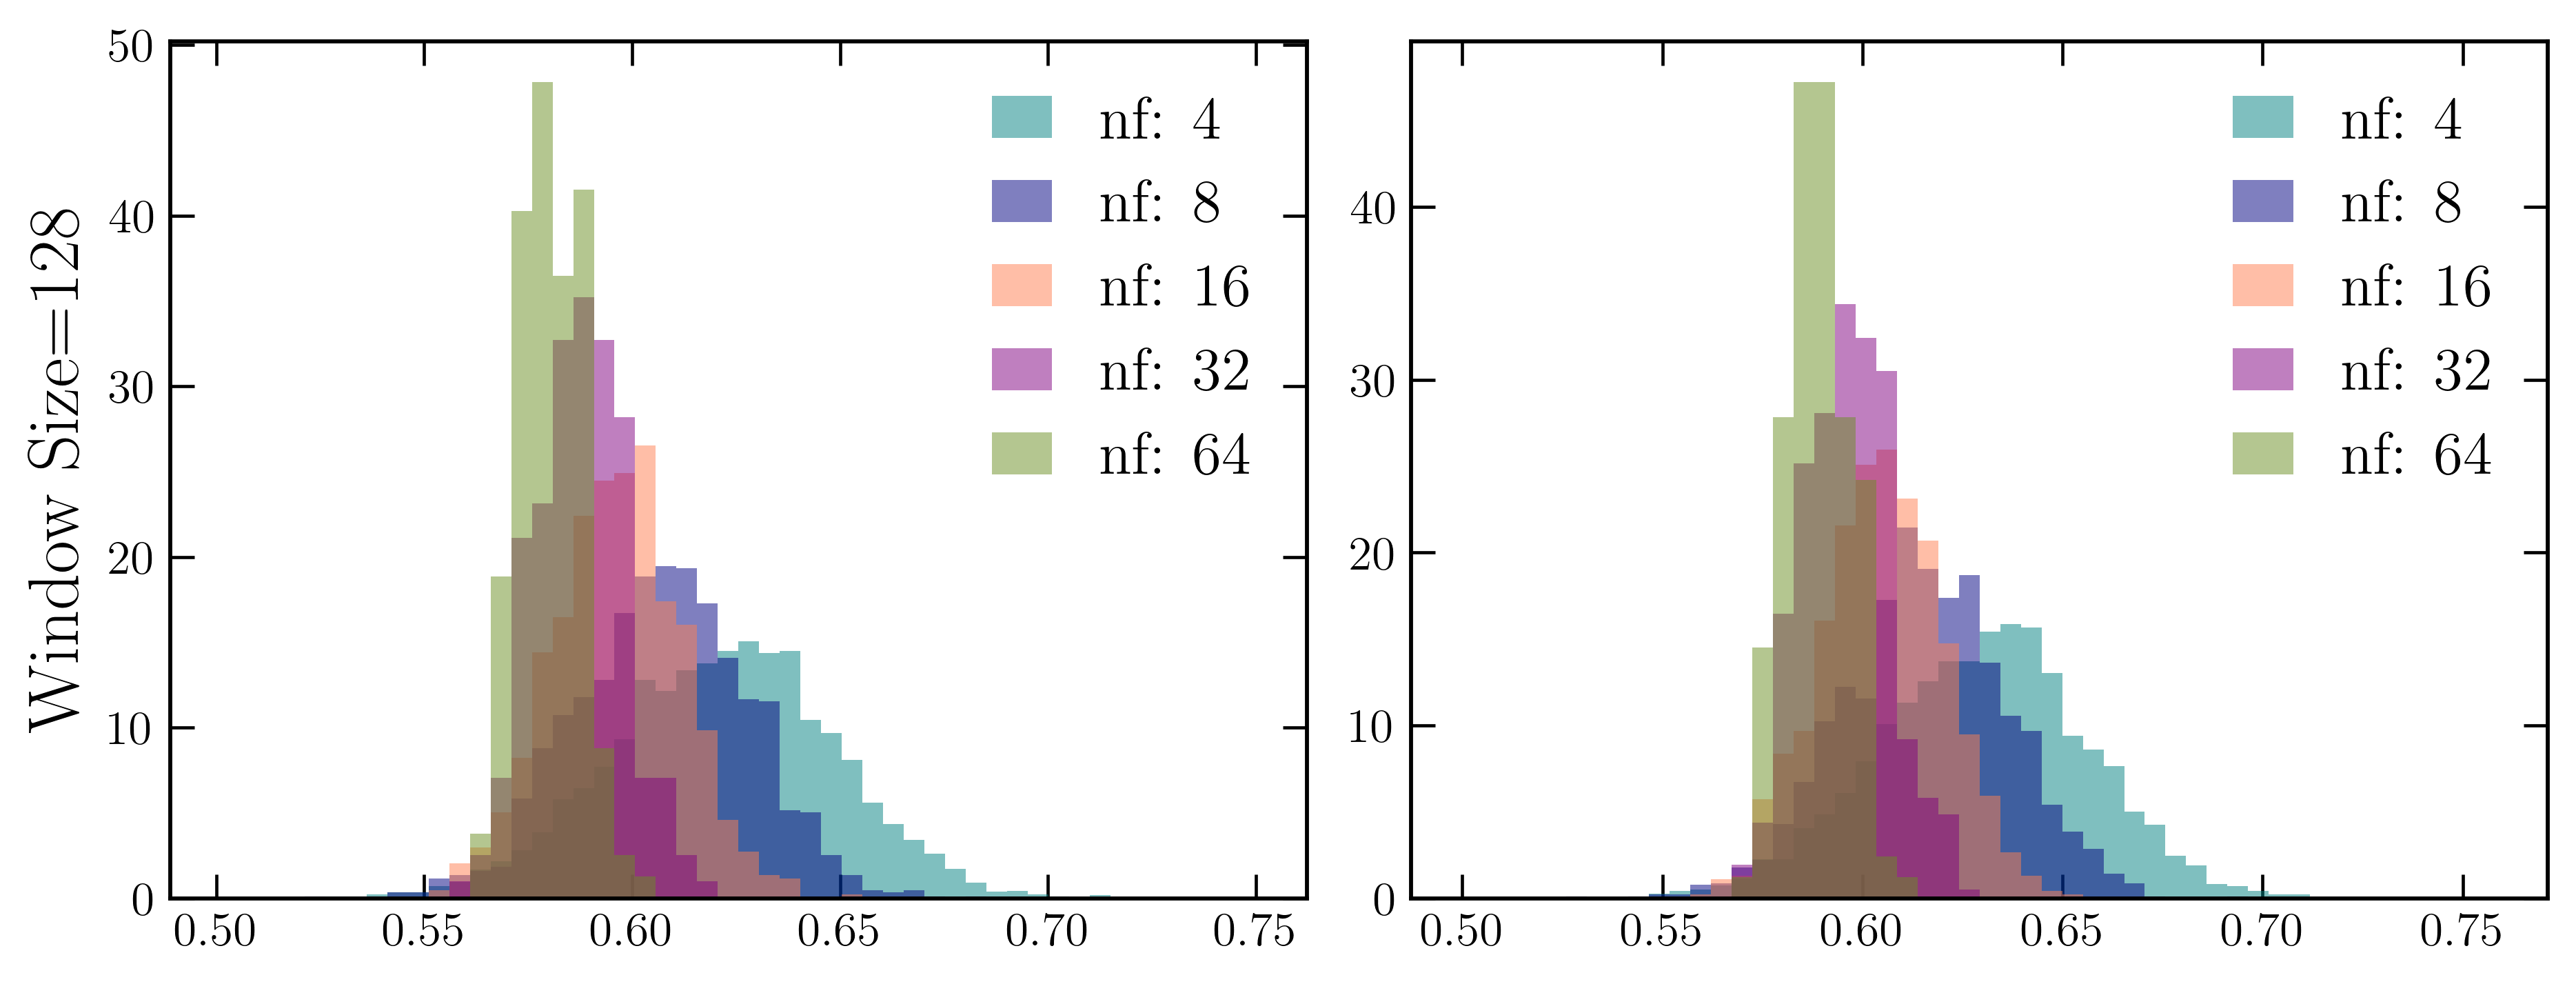

In [116]:
data_suffix='na512'
LL = data_dict[data_suffix]['L_list'][0]
save_fig=True
plot_abs = False
plot_cid_per = True 
use_cidm=False
zero_fluctuation_point = 0
mode = 'div' # 'cid' or 'div'

actp=0.06
bins=50
rangec_dict={0.022:(0.04,0.14), 0.04:(0.4,0.46)}
rangecs_dict={0.022:(0.06,0.18), 0.04:(0.42,0.48)}

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\nematic\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)
figpath

window_size_list = window_size_dict[data_suffix]
nsizes_list = nsizes_dict[data_suffix]

window_size_list = [128,]
nsizes_list = [4, 8,16,32, 64]
bins_dict = {128: 50, 256: 50, 512: 40, 1024:40}

#fig, ax = plt.subplots(ncols = 3 if plot_cid_per and mode=='cid' else 2, nrows = len(window_size_list), figsize=(15 if plot_cid_per and mode=='cid' else 10,3.5*len(window_size_list)))
nrows=len(window_size_list)
ncols=2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,3.5*nrows))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
for j, window_size in enumerate(window_size_list):

    axx = ax[j] if len(window_size_list) > 1 else ax
    if window_size ==512: 
        data_suffix='na1024'
        nsizes_list = [32, 60]
    if window_size ==1024:
        data_suffix='na2048'
        nsizes_list = [32,64]

    #cg = data_dict[data_suffix]['cg']
    LL = data_dict[data_suffix]['L_list'][0]
    ac_list = []
    cidval_min_list = []
    for size in nsizes_list:
        cid_dict.update(data_dict[data_suffix])
        cg = cid_dict['cg']
        cid_dict.update({
            'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
        })
        ac_tmp = AnalyseCID(cid_dict, load_data=True)
        hyperwindow_shape_cg = ac_tmp.cid_params[LL]['hyperwindow_shape_cg']
        print(hyperwindow_shape_cg)

        empty_cube = np.zeros(hyperwindow_shape_cg).astype(np.uint8).flatten()

        cidval_min = calc_cid(empty_cube)
        cidval_min_list.append(cidval_min)
        print(f'CID min value for empty cube: {cidval_min}')
        ac_list.append(ac_tmp)
        
    rangec = None #if actp not in rangec_dict else rangec_dict[actp]
    rangecs = None #if actp not in rangecs_dict else rangecs_dict[actp]

    for i, size in enumerate(nsizes_list[:]):


        ac_tmp = ac_list[i]
        act = ac_tmp.act[LL].copy()

        hyperwindow_shape_cg = ac_tmp.cid_params[LL]['hyperwindow_shape_cg']
        print(hyperwindow_shape_cg)

     #   empty_cube = np.zeros(hyperwindow_shape_cg).astype(np.uint8).flatten()

      #  cidval_min = calc_cid(empty_cube)
        #  cidval_min_list.append(cidval_min)
        cid_val_min = cidval_min_list[i]
        cidval_min_rel = 1 # cidval_min_list[i] / cidval_min_list[-1]

      #  print(f'CID min value for empty cube: {cidval_min}')



        cid = ac_tmp.cid[LL].copy()
        cidm= ac_tmp.cidm[LL].copy()
        cid_shuffle = ac_tmp.cid_shuffle[LL].copy()
        frac = ac_tmp.frac[LL].copy()

        dcid = ac_tmp.dcid[LL].copy()
        dfrac = ac_tmp.dfrac[LL].copy()
        div_tav = dfrac.copy()
        div_tav[:,0] *= -1

        cid_tav = ac_tmp.cid_tav[LL].copy()
        frac_tav = ac_tmp.frac_tav[LL].copy()
        div_tav = frac_tav.copy()
        div_tav[...,0] = 1 - frac_tav[...,0]

        cid_var = ac_tmp.cid_var[LL].copy()
        div_var = ac_tmp.frac_var[LL].copy()

        normalizer = np.abs(zero_fluctuation_point - cid_tav[:,0])
        deriv_cid_per = dcid / normalizer[:, None]
        deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
        if plot_abs:
            deriv_cid_per = np.abs(deriv_cid_per)

        vals_av = cid_tav if mode == 'cid' else div_tav
        dvals = dcid if mode == 'cid' else dfrac



        act_idx = np.where(act==actp)[0][0]
        if use_cidm:
            cid_vals_hist = cidm[:, :, act_idx, :, 0].flatten() - cidval_min
        else:
            cid_vals_hist = cid[:, :, act_idx, :, 0].flatten() - cidval_min
        cid_shuffle_vals_hist = cid_shuffle[:, :, act_idx, :, 0].flatten() - cidval_min

        if rangec is None:
            rangec = (np.nanmin(cid_vals_hist)*0.95, np.nanmax(cid_vals_hist)*1.05)
        if rangecs is None:
            rangecs = (np.nanmin (cid_shuffle_vals_hist)*0.95, np.nanmax(cid_shuffle_vals_hist)*1.05)

      #  hist_range = (min(rangec[0], rangecs[0]), max(rangec[1], rangecs[1]))
       # rangec=None
       # rangecs=None

        bins=bins_dict[window_size]

        axx[0].hist(cid_vals_hist, bins=bins, range=rangec , density=True, alpha=0.5, label=f'nf: {size}')
        axx[1].hist(cid_shuffle_vals_hist, bins=bins, range=rangecs , density=True, alpha=0.5, label=f'nf: {size}')

    axx[0].legend()
    axx[1].legend()
    axx[0].set_ylabel(f'Window Size={window_size}')
#ax[0,0].set_title(f'CID Distribution at act={actp}') 
#ax[0,1].set_title(f'CID Shuffle Distribution at act={actp}')

In [133]:
data_suffix='na512'
window_size_list = window_size_dict[data_suffix]
window_size_list

[16, 32, 64, 128, 256, 512, 1024, 512, 1024]

In [135]:
xlims_dict

{'na512': [0.018, 0.035],
 'na1024': [0.018, 0.035],
 'na2048': [0.018, 0.035],
 'ndg': None,
 'pol': None,
 's': None,
 'abp': None}

Figure saved to: data\figs\na512\scaling\cid_cidvar_relative.pdf


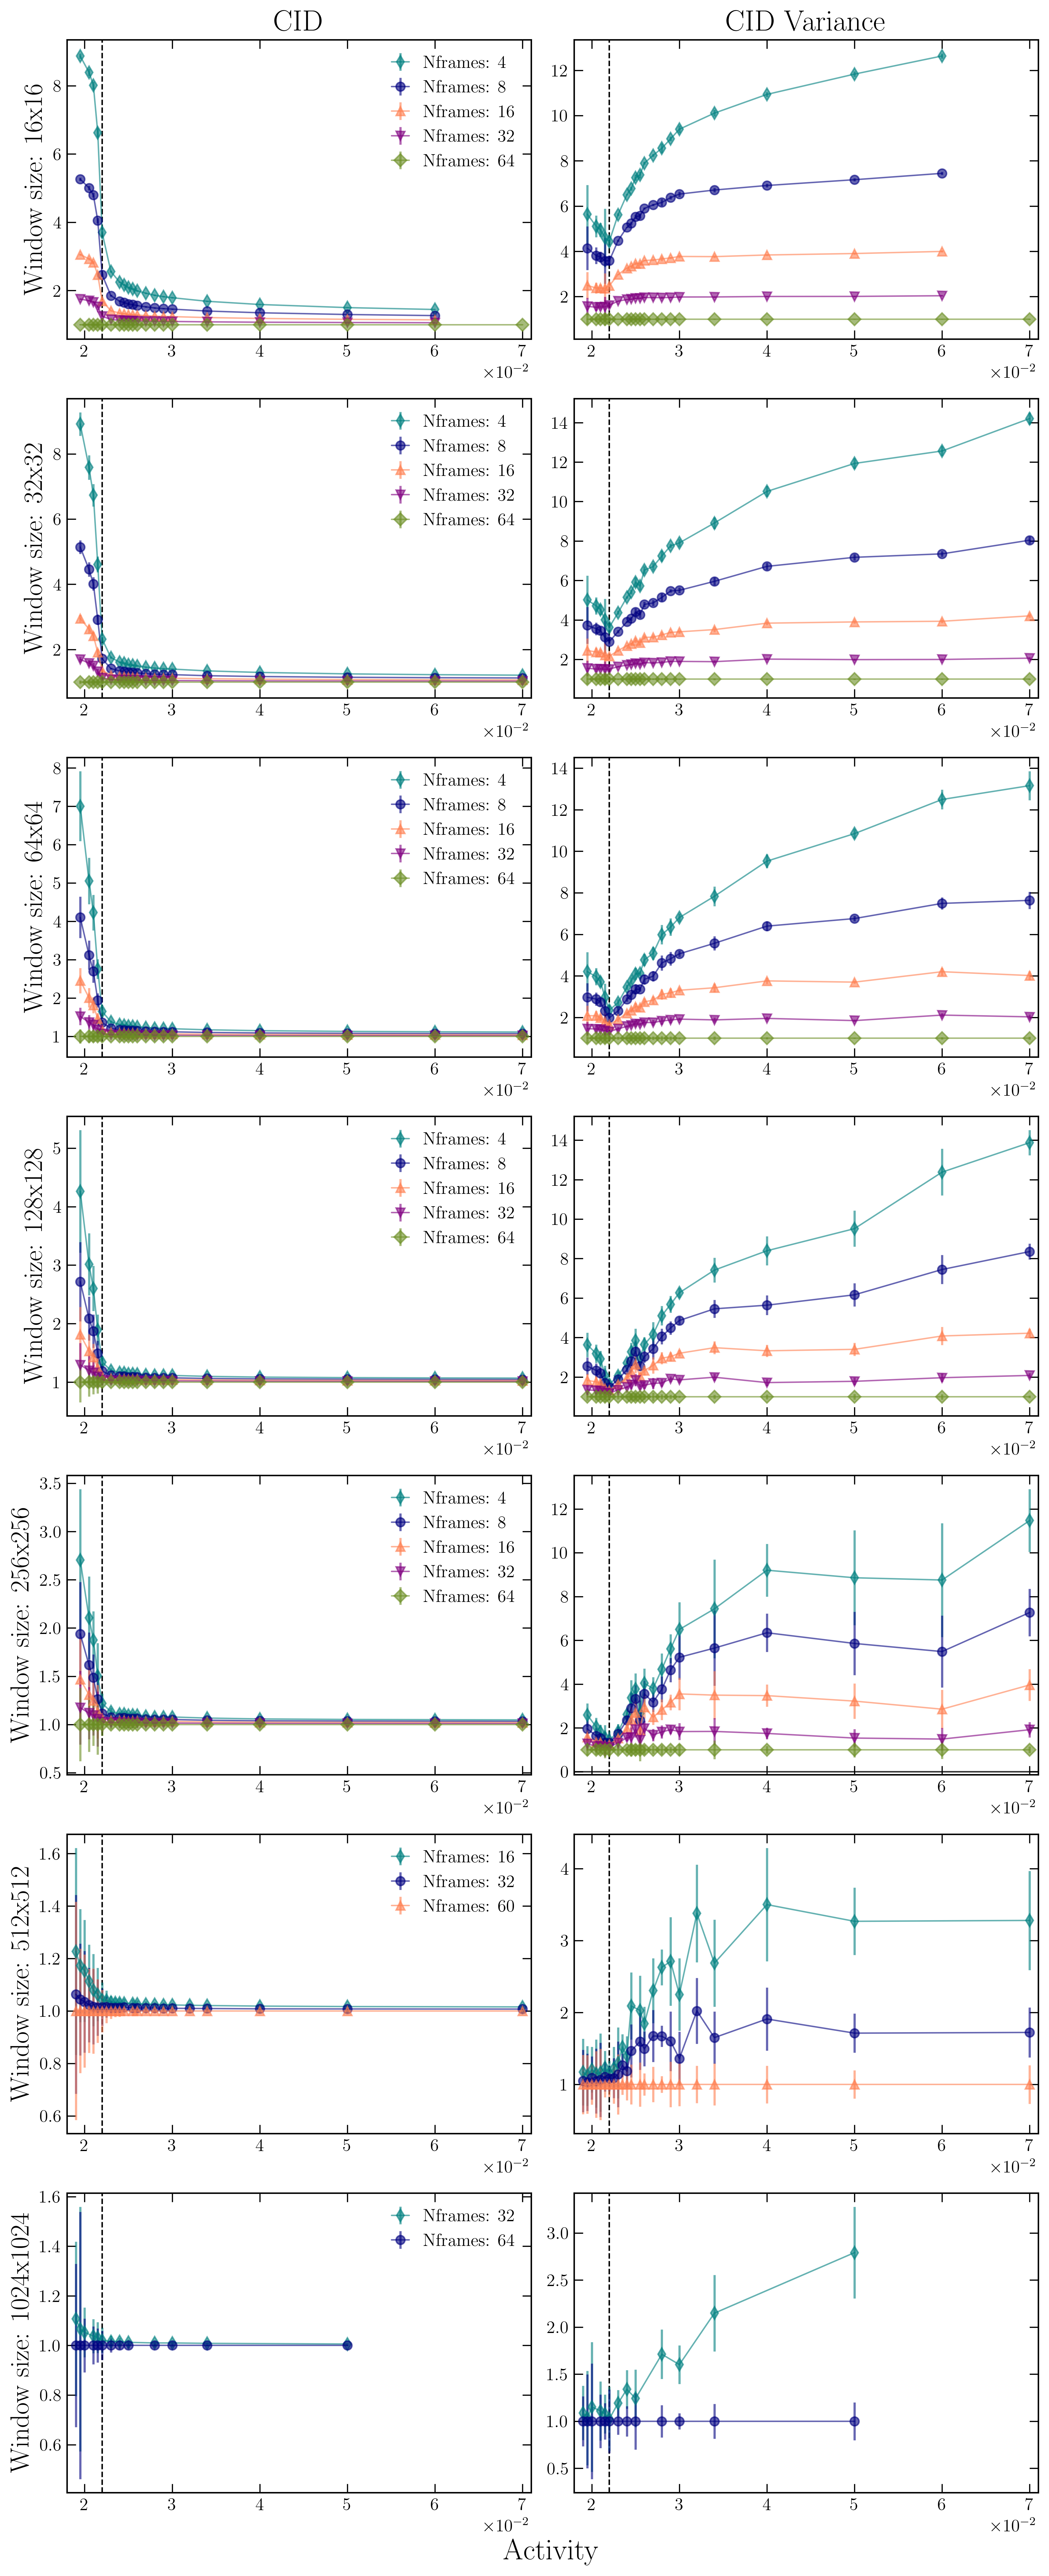

In [138]:
data_suffix='na512'
LL = data_dict[data_suffix]['L_list'][0]
save_fig=True
plot_abs = False
plot_cid_per = True 
zero_fluctuation_point = 0
mode = 'cid' # 'cid' or 'div'
coarse_graining_box_length = ac.cid_params[LL]['coarse_graining_box_length']

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)
figpath

window_size_list = [16, 32, 64, 128, 256, 512, 1024,]

#window_size_list.extend([512,1024])
nsizes_list = nsizes_dict[data_suffix]

#fig, ax = plt.subplots(ncols = 3 if plot_cid_per and mode=='cid' else 2, nrows = len(window_size_list), figsize=(15 if plot_cid_per and mode=='cid' else 10,3.5*len(window_size_list)))
fig, ax = plt.subplots(ncols = 2, nrows = len(window_size_list), figsize=(10,3.5*len(window_size_list)))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
for j, window_size in enumerate(window_size_list):

    axx = ax[j] if len(window_size_list) > 1 else ax

    if window_size ==512: 
        data_suffix='na1024'
        nsizes_list = [16, 32, 60]
    if window_size ==1024:
        data_suffix='na2048'
        nsizes_list = [32,64]

    cg = data_dict[data_suffix]['cg'] if 'cg' in data_dict[data_suffix] else coarse_graining_box_length
    LL = data_dict[data_suffix]['L_list'][0]
    ac_list = []
    for size in nsizes_list:
        cid_dict.update(data_dict[data_suffix])
        cid_dict.update({
            'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
        })
        ac_tmp = AnalyseCID(cid_dict, load_data=True)
        ac_list.append(ac_tmp)

    for i, size in enumerate(nsizes_list[:]):

        ac_tmp = ac_list[i]
        act = ac_tmp.act[LL].copy()
        
        cid = ac_tmp.cid[LL].copy()
        cid_shuffle = ac_tmp.cid_shuffle[LL].copy()
        frac = ac_tmp.frac[LL].copy()

        cid_tav_ref = ac_list[-1].cid_tav[LL].copy()
        cid_var_ref = ac_list[-1].cid_var[LL].copy()

        dcid = ac_tmp.dcid[LL].copy()
        dfrac = ac_tmp.dfrac[LL].copy()
        div_tav = dfrac.copy()
        div_tav[:,0] *= -1

        cid_tav = ac_tmp.cid_tav[LL].copy()
        frac_tav = ac_tmp.frac_tav[LL].copy()
        div_tav = frac_tav.copy()
        div_tav[...,0] = 1 - frac_tav[...,0]

        cid_var = ac_tmp.cid_var[LL].copy()
        div_var = ac_tmp.frac_var[LL].copy()

        normalizer = np.abs(zero_fluctuation_point - cid_tav[:,0])
        deriv_cid_per = dcid / normalizer[:, None]
        deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
        if plot_abs:
            deriv_cid_per = np.abs(deriv_cid_per)

       # vals_av = cid_tav if mode == 'cid' else div_tav
        vals_av = cid_tav / cid_tav_ref[...,0][:,None]
        frac_std = vals_av[:,0] * np.sqrt( (cid_tav[:,1] / cid_tav[:,0])**2 + (cid_tav_ref[:,1] / cid_tav_ref[:,0])**2 )
        vals_av[:,1 ] = frac_std

        cid_var = cid_var / cid_var_ref[...,0][:,None]
        varfrac_std = cid_var[:,0] * np.sqrt( (cid_var[:,1] / cid_var[:,0])**2 + (cid_var_ref[:,1] / cid_var_ref[:,0])**2 )
        cid_var[:,1] = varfrac_std


        dvals = dcid if mode == 'cid' else dfrac

        axx[0].errorbar(act,vals_av[:, 0],yerr=vals_av[:, 1],
        fmt=marker_shape[i % len(marker_shape)],
        lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
        elinewidth=1.5, alpha=0.6   )
        axx[1].errorbar(act,cid_var[:, 0],yerr=cid_var[:, 1],
            fmt=marker_shape[i % len(marker_shape)],
            lw=1,label=f'Window size: {size}' if not iterate_frames else f'Nframes: {size}',
            elinewidth=1.5, alpha=0.6   )

    axx[0].legend(fontsize=12)
    axx[0].set_ylabel(f'Window size: {window_size_list[j]}x{window_size_list[j]}')
    
    for a in axx:
        if xlims_dict[data_suffix] is not None:
            #a.set_xlim(*xlims_dict[data_suffix])
            a.set_xlim([0.018, 0.071])
        else:
            a.set_xlim(a.get_xlim())

        a.set_ylim(a.get_ylim())  
        a.tick_params(axis='both',which='major',)
        a.hlines(0, *a.get_xlim(), colors='black', linestyles='solid', lw=1, alpha=0.8,zorder=-5)
        a.vlines(cid_dict['act_critical'], *a.get_ylim(), color='k', linestyle='--', zorder=-5, lw=1)
    if j == 0:
        axx[0].set_title('CID' if mode == 'cid' else r'$\mathcal{D}$', fontsize=20)
        axx[1].set_title('CID Variance' if mode == 'cid' else r'$\mathcal{D}$ Variance', fontsize=20)
       
fig.supxlabel('Activity', ha='center', x=0.525, fontsize=20)
fig.tight_layout()
if mode == 'cid':
    dcid_per_label = 'dcidp' if zero_fluctuation_point == 0 else 'dcidp_shifted'
    savepath = os.path.join(figpath, f'cid_cidvar_relative.pdf')
else:
    savepath = os.path.join(figpath, f'div_divvar_relative.pdf')
if save_fig: 
    fig.savefig(savepath, bbox_inches='tight', dpi=620, pad_inches=0.05)
    print(f"Figure saved to: {savepath}")

In [131]:
window_size_list

[16, 32, 64, 128, 256, 512, 1024, 512, 1024]

In [ ]:
LL = ac.L_list[0]
window_size=256
nframes=64
#cg = data_dict[data_suffix]['cg']
LL = data_dict[data_suffix]['L_list'][0]
ac_list = []

nsizes_list = nsizes_dict[data_suffix]
for size in nsizes_list:
    cid_dict.update(data_dict[data_suffix])
    cg = cid_dict['cg']
    cid_dict.update({
        'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
    })
    ac_tmp = AnalyseCID(cid_dict, load_data=True)
    ac_list.append(ac_tmp)

cs = ac.cid_shuffle[LL][...,0]
cs_var = np.nanvar(cs, axis=(0,1,))
cs_varav = np.nanmean(cs_var, axis=(-1))
cs_varsem = np.nanstd(cs_var, axis=(-1)) / np.sqrt(cs_var.shape[-1])

cid_var = ac.cid_var[LL]
cidm_var = ac.cidm_var[LL]

plt.errorbar(ac.act[LL], cs_varav, yerr=cs_varsem, fmt='o-', label='CID Shuffle Variance')
plt.errorbar(ac.act[LL], cid_var[:,0], yerr=cid_var[:,1], fmt='d-', label='CID Variance')
plt.errorbar(ac.act[LL], cidm_var[:,0], yerr=cidm_var[:,1], fmt='s-', label='CIDM Variance')

#plt.vlines(0.022, 0, 0.015, colors='k', linestyles='dashed', label='$a_c$')
plt.legend()

In [32]:

LX=ac.L_list[0]
actidx=5
expidx=0
compression_factor = ac.cid_params[LX]['compression_factor']
cid_vals=ac.cid[LX][:,:,actidx,expidx,0].reshape(-1, compression_factor, compression_factor)
cid_vals.shape

(50, 16, 16)

In [36]:
# Set correlation parameters
abs_val = True # when True, the degeneracy in the director is resolved
auto_corr_kwargs = {'shift': 2/np.pi if abs_val is True else 9/(7*np.pi),
                    'abs_val': abs_val, 
                    'normalize': True}
auto_corr_kwargs = {'shift': 0,
                    'abs_val': abs_val, 
                    'normalize': True}

origin=True
step=1

rdf, _ = rdf2d_mod(cid_vals[0], corr_func_kwargs = auto_corr_kwargs, \
                                 origin=origin, step=step)